In [ ]:
%reload_ext autoreload
%autoreload 2
import glob
import numpy as np
import logging
import os
import csv

from pyrfu import mms
from pyrfu import pyrf
from pyrfu.plot import plot_line

# Suppress INFO messages
logger = logging.getLogger()
logger.setLevel(logging.WARNING)  # Suppress INFO messages

def _read_regionfiles_to_swtints(folder, ic):
    print(f'Region files for MMS{ic} at...',end='')
    
    # Get region file for specified S/C names by glob
    dir_regs = "mms-regionfiles/"
    file_pattern = dir_regs + f"mms{ic}_edp_sdp_regions_*"
    filenames = glob.glob(file_pattern)
    print(f'{file_pattern}')
    
    # Initialize an empty list to store the tint pairs
    sw_tints = []

    for filepath in filenames:
        print('\t'+filepath)
        # Load data with times and region flags
        region_data = np.genfromtxt(filepath, skip_header=True, dtype=str)
        times, region_flags = np.hsplit(region_data, 2)

        # Iterate through rows and check region flag for solar wind region (flag == '1')
        nrows = len(times)
        for row in range(1, nrows - 1):
            if region_flags[row] == '1':
                # Create a tint spanning from times[i-1] to times[i+1]
                sw_tint = [times[row][0][:-1], times[row+1][0][:-1]]
                
                # Prevent duplicates: Check if tint is unique. If not, do not add
                if sw_tint not in sw_tints:
                    sw_tints.append(sw_tint)

    # Convert the list of tints to a NumPy array
    sw_tints = np.array(sw_tints)
    filename = f'mms{ic}_sw_tints.txt'
    print('\t'+20*'-')
    print('\t>'+f' Saving to {folder+filename}...')
    print('\t'+20*'-'+'\n')
    np.savetxt(folder+filename, sw_tints, fmt='%s', delimiter=' ')
    return sw_tints, filename
        


def _check_vsc(ts_mask, tint, ic):
    try:
        vsc_ = mms.get_data("v_edp_fast_l2", tint, ic)
    except FileNotFoundError:
        # print('NO EDP DATA FOUND FOR TINT', tint, '--- SKIPPING!')
        return None
    
    vsc = vsc_.drop_duplicates(dim='time')
    # ts_mask = pyrf.resample(ts_mask, vsc.time)
    vsc = pyrf.resample(vsc, ts_mask.time)

    if vsc.time.size > 0:
        # ts_mask[np.isnan(vsc)] = np.nan
        ts_mask[np.isnan(vsc)] = 0

    else:
        # print('SPACECRAFT POTENTIAL EMPTY')
        # ts_mask[:] = np.nan
        ts_mask[:] = 0

        
    return ts_mask

def _check_aspoc(ts_mask, tint, ic):
    try:
        aspoc = mms.get_data('ionc_aspoc_srvy_l2', tint, ic)
    except FileNotFoundError:
        # print('NO ASPOC DATA FOR', tint, '--- SKIPPING')
        return None

    # Keep only data where ASPOC is OFF (< 5), else NaN
    aspoc_off = aspoc.where(aspoc < 2, other=0)

    ts_mask = pyrf.resample(ts_mask, aspoc_off.time)
    # ts_mask[np.isnan(aspoc_off)] = np.nan
    ts_mask[np.isnan(aspoc_off)] = 0

    
    return ts_mask

def _split_tint(data, tint):
    # Identify the time index where data jumps to/from NaN
    diff = data.differentiate(coord='time')
    diff_norm = diff / np.max(diff)
    toggle_idxs = np.where(np.abs(diff_norm) > 0.1)[0]
    if data.data[-1] == 1.0:
        toggle_idxs = np.append(toggle_idxs, -1)
    valid_tints = []
    start = 0
    for idx in toggle_idxs:
        start_time, end_time = data.time.data[start], data.time.data[idx]
        dt = np.timedelta64(end_time - start_time)
        if (np.all(data.data[start:idx] == 1)) & (dt > np.timedelta64(10,'s')):
            
            valid_tint = [str(start_time), str(end_time)]
            valid_tints.append(valid_tint)
            
        start = idx+1

    if len(valid_tints) > 0:
        # print(f'\tCutting tint from {tint} to:')
        for valid_tint in valid_tints:
            a = 0
            # print(f'\t{valid_tint}')

    else:
        # print('\tNO INTERVALS WHERE DATA IS NaN WAS FOUND.')
        valid_tints = tint
    return valid_tints

def _check_swmode(tint, ic):
    ### Detect FPI operational mode
    # 0 - Solar wind mode OFF
    # 1 - Solar wind mode ON
    # 2 - FPI data not available
    try:
        dis = mms.get_data('defi_fpi_fast_l2', tint, ic)
        dis_energies = dis.energy.data
        # Solar wind tables from G-41 in
        # https://spdf.gsfc.nasa.gov/pub/data/mms/documents/MMS-CMAD.pdf
        minDISEnergy_sw, maxDISEnergy_sw = 210.0, 8700.0
        if np.min(dis_energies) == minDISEnergy_sw and np.max(dis_energies) == maxDISEnergy_sw:
            sw_mode = 1
        else:
            sw_mode = 0
            
    except ValueError as e:
        # print(e)
        sw_mode = 2

    return sw_mode

def _preprocess_tints(sw_tints, filepath, ic, flag_swmode = True, flag_foreshock = False):
    if not os.path.exists(filepath):
        output_header = ['start', 'end', 'ic', 'swmode']
        with open(filepath, "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerow(output_header)
    
    # Loop through time intervals in sw_tints
    for i,tint in enumerate(sw_tints):
        print(f'[{ic}]: {i+1}/{len(sw_tints)}', end='\r', flush=True)
        tint = tint.tolist()
        
        ### Create mask time series that is == 1 for intervals to keep, and == 0 for unwanted intervals
        ts_axis = np.arange(np.datetime64(tint[0]), np.datetime64(tint[-1]), np.timedelta64(1,'s')).astype('datetime64[ns]')
        ts_data = np.ones_like(ts_axis)
        ts_mask = pyrf.ts_scalar(ts_axis, ts_data)
                
        ### Check if spacecraft potential data from EDP is availale
        ts_mask_vsc = _check_vsc(ts_mask, tint, ic)
        if ts_mask_vsc is None:
            # print('SKIPPING')
            continue
      
        ### ASPOC status
        ts_mask_vsc_aspoc = _check_aspoc(ts_mask_vsc, tint, ic)
        if ts_mask_vsc_aspoc is None:
            # print('SKIPPING')
            continue
        
        valid_tints = _split_tint(ts_mask_vsc_aspoc, tint)


        # for each valid tint in valid_tints, check SW mode and write to file
        for valid_tint in valid_tints:
            sw_mode = _check_swmode(valid_tint, ic)
            vsc_ = mms.get_data("v_edp_fast_l2", tint, ic)
            aspoc = mms.get_data('ionc_aspoc_srvy_l2', tint, ic)


            # with open(filepath, 'a', newline='') as f:
            #     writer = csv.writer(f)
            #     output = [valid_tint[0], valid_tint[1], ic, sw_mode]
            #     writer.writerow(output)
    print()


def main(folder='sw_tints/', ics = [1, 2, 3, 4]):
    if type(ics) == int:
        ics = [ics]
        
    for ic in ics:
        # sw_tints, filename = _read_regionfiles_to_swtints(folder, ic)
        filename = f'mms{ic}_sw_tints.txt'
        sw_tints = np.genfromtxt(folder+filename, dtype=str)
        _preprocess_tints(sw_tints[:], folder+'compiled_sw_tints', ic)

#main()


Load IGRF coefficients ...


# Test split tints

In [9]:
import glob
import numpy as np
import logging
import os
import csv
import sys
import time
import matplotlib.pyplot as plt
from pyrfu import mms, pyrf
from pyrfu.plot import plot_line
import multiprocessing as mp

def _check_vsc(ts_mask, tint, ic):
    try:
        vsc_ = mms.get_data("v_edp_fast_l2", tint, ic)
    except FileNotFoundError:
        # print('NO EDP DATA FOUND FOR TINT', tint, '--- SKIPPING!')
        return None

    if vsc_.time.size > 0:
        vsc = vsc_.drop_duplicates(dim='time')
        vsc = pyrf.resample(vsc, ts_mask.time)#, method='linear')
        # Make exception for single NaN in vsc, can happen when time series goes over midnight?
        nans = np.argwhere(np.isnan(vsc.data))[:,0]
        ts_mask[nans] = 0
        if len(nans) < 10:
            for nan in nans:
                if vsc[nan-1] != None and vsc[nan+1] != None:
                    ts_mask[nan] = 1
        
    else:
        ts_mask[:] = 0
        
    return ts_mask

def _check_aspoc(ts_mask, tint, ic):
    try:
        aspoc = mms.get_data('ionc_aspoc_srvy_l2', tint, ic).drop_duplicates(dim='time')
    except FileNotFoundError:
        # print('NO ASPOC DATA FOR', tint, '--- SKIPPING')
        return None
    
    aspoc = pyrf.resample(aspoc, ts_mask.time, method='linear')

    # Keep only data where ASPOC is OFF (< 2), else NaN
    aspoc_off = aspoc.where(aspoc < 2, other=None)

    # ts_mask = pyrf.resample(ts_mask, aspoc_off.time)
    

    ts_mask[np.isnan(aspoc_off)] = 0
 

    
    return ts_mask

def _split_tint(data, tint):
    # Identify the time index where data jumps to/from NaN
    try:
        diff = data.differentiate(coord='time')
    except ValueError as e:
        return None
    
    diff_norm = diff / (np.max(diff) + 1e-9)
    toggle_idxs = np.where(np.abs(diff_norm) > 0.1)[0]
    
    # Make sure end point of tint is included if mask == 1 there
    if data.data[-1] == 1.0:
        toggle_idxs = np.append(toggle_idxs, -1)

    valid_tints = []
    start = 0
    for idx in toggle_idxs:
        start_time, end_time = data.time.data[start], data.time.data[idx]
        dt = np.timedelta64(end_time - start_time)
        if (np.all(data.data[start:idx] == 1)) & (dt > np.timedelta64(10,'s')):
            valid_tint = [str(start_time), str(end_time)]
            valid_tints.append(valid_tint)

        start = idx+1

    return valid_tints if len(valid_tints) > 0 else [tint]

def _check_swmode(tint, ic):
    ### Detect FPI operational mode
    # 0 - Solar wind mode OFF
    # 1 - Solar wind mode ON
    # 2 - FPI data not available
    try:
        dis = mms.get_data('defi_fpi_fast_l2', tint, ic)
        dis_energies = dis.energy.data
        # Solar wind tables from G-41 in
        # https://spdf.gsfc.nasa.gov/pub/data/mms/documents/MMS-CMAD.pdf
        minDISEnergy_sw, maxDISEnergy_sw = 210.0, 8700.0
        if np.min(dis_energies) == minDISEnergy_sw and np.max(dis_energies) == maxDISEnergy_sw:
            sw_mode = 1
        else:
            sw_mode = 0
            
    except (ValueError, FileNotFoundError, TypeError) as e:
        # print(e)
        sw_mode = 2

    return sw_mode


def _log_failed(failpath, tint, ic, message, index):
    with open(failpath, 'a', newline='') as f:
        writer = csv.writer(f)
        output = [tint[0], tint[1], ic, 2, message, index]
        writer.writerow(output)
    print(f'({index+1})', end=' ', flush=True)
    

def _preprocess_tint(tint, index, filepath, failpath, ic, print_progress = False):
    if type(tint) != list:
        tint = tint.tolist()
    if len(tint) != 2:
        _log_failed(failpath, tint, ic, 'Tint len != 2', index)
        return  
    
    ### Create mask time series that is == 1 for intervals to keep, and == 0 for unwanted intervals
    ts_axis = np.arange(np.datetime64(tint[0]), np.datetime64(tint[-1]), np.timedelta64(1,'s')).astype('datetime64[ns]')
    ts_data = np.ones_like(ts_axis)
    ts_mask = pyrf.ts_scalar(ts_axis, ts_data)
            
    ### Check if spacecraft potential data from EDP is availale
    ts_mask_vsc = _check_vsc(ts_mask, tint, ic)
    if ts_mask_vsc is None:
        _log_failed(failpath, tint, ic, '_check_vsc failed', index)
        return
    
    ### ASPOC status
    ts_mask_vsc_aspoc = _check_aspoc(ts_mask_vsc, tint, ic)
    if ts_mask_vsc_aspoc is None:
        _log_failed(failpath, tint, ic, '_check_aspoc failed', index)
        return
    
    ### Split original tint into smaller ones where both ASPOC OFF and Vsc available
    valid_tints = _split_tint(ts_mask_vsc_aspoc, tint)
    if valid_tints is None:
        _log_failed(failpath, tint, ic, '_split_tint failed', index)
        return

    # For each valid tint in valid_tints, check SW mode and write to file
    for valid_tint in valid_tints:
        sw_mode = _check_swmode(valid_tint, ic)
        with open(filepath, 'a', newline='') as f:
            writer = csv.writer(f)
            output = [valid_tint[0], valid_tint[1], ic, sw_mode]
            writer.writerow(output)
    # Print progress
    if print_progress:
        update_percent = numtot // 21
        if np.mod(index, update_percent) == 0:
            # print(f'{(index/numtot)*100:.2f} %', end=' ', flush=True)
            print(f'|', end='', flush=True)
            
    return valid_tints


[14-Apr-25 16:24:49] INFO: Loading mms1_edp_scpot_fast_l2...
[14-Apr-25 16:24:50] INFO: Using averages in resample
[14-Apr-25 16:24:50] INFO: Loading mms1_aspoc_ionc...
[14-Apr-25 16:24:50] INFO: Loading mms1_dis_energyspectr_omni_fast...
[14-Apr-25 16:24:50] INFO: Loading mms1_des_numberdensity_fast...
[14-Apr-25 16:24:50] INFO: Loading mms1_aspoc_ionc...
[14-Apr-25 16:24:50] INFO: Loading mms1_des_numberdensity_fast...
[14-Apr-25 16:24:50] INFO: Loading mms1_aspoc_ionc...


[['2024-05-03T16:00:00.000000000', '2024-05-04T09:40:00.00']]


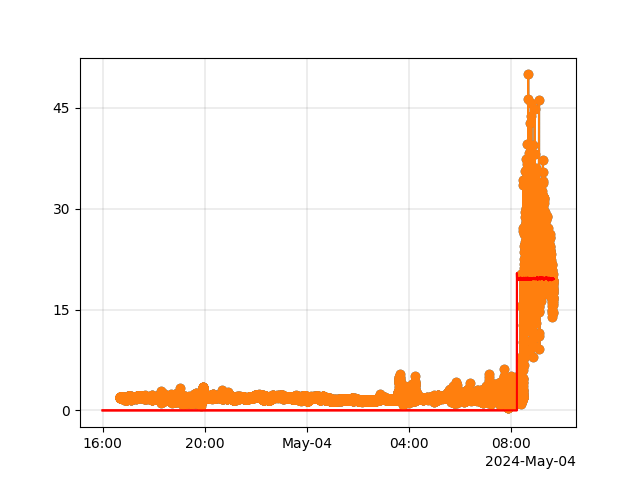

In [27]:
%matplotlib widget
plt.close('all')
test_tint = ['2024-05-03T16:00:00.000000000', '2024-05-04T09:40:00.00']
# test_tint = ['2024-05-08T22:01:55.000000000', '2024-05-10T00:30:59.226928000']
ic = 1
valid_tints = _preprocess_tint(test_tint, 0, 'test.csv', 'testfail.csv', ic, print_progress = False)
fig, ax = plt.subplots(1)
vsc_dt = mms.get_data('ne_fpi_fast_l2', test_tint, ic).drop_duplicates(dim='time')
aspoct = mms.get_data('ionc_aspoc_srvy_l2', test_tint, ic).drop_duplicates(dim='time')

plot_line(ax, vsc_dt, marker='o')
plot_line(ax, aspoct, color='red')

print(valid_tints)
for vt in valid_tints:
    vsc_d = mms.get_data('ne_fpi_fast_l2', vt, ic).drop_duplicates(dim='time')
    aspoc = mms.get_data('ionc_aspoc_srvy_l2', vt, ic).drop_duplicates(dim='time')
    
    plot_line(ax, vsc_d, marker='o')
    plot_line(ax, aspoc, color='red')
    
    